In [23]:
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.stats import ttest_rel

## Data preprocessing
Due to a generally high SNR in SSVEP/vSSR, typical preprocessing steps
are considered optional. This doesn't mean, that a proper cleaning would not
increase your signal quality!

* Raw data have FCz reference, so we will apply common-average rereferencing.

* We  will apply a 0.1 highpass filter.

* Lastly, we will cut the data in 20 s epochs corresponding to the trials.





In [25]:
# Load raw data
data_path = '/Users/kohler/Desktop/oba_eeg_data/shaya_20221125/shaya_20221125_020929.mff'

raw = mne.io.read_raw_egi(data_path, preload=True)
raw.info['line_freq'] = 60. 

# Set montage
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
raw.set_montage(montage, match_alias=True)

# Set common average reference
raw.set_eeg_reference('average', projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=None, fir_design='firwin', verbose=False)

Reading EGI MFF Header from /Users/kohler/Desktop/oba_eeg_data/shaya_20221125/shaya_20221125_020929.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 723178  =      0.000 ...   723.178 secs...


<RawMff | signal1.bin, 131 x 723179 (723.2 s), ~723.0 MB, data loaded>

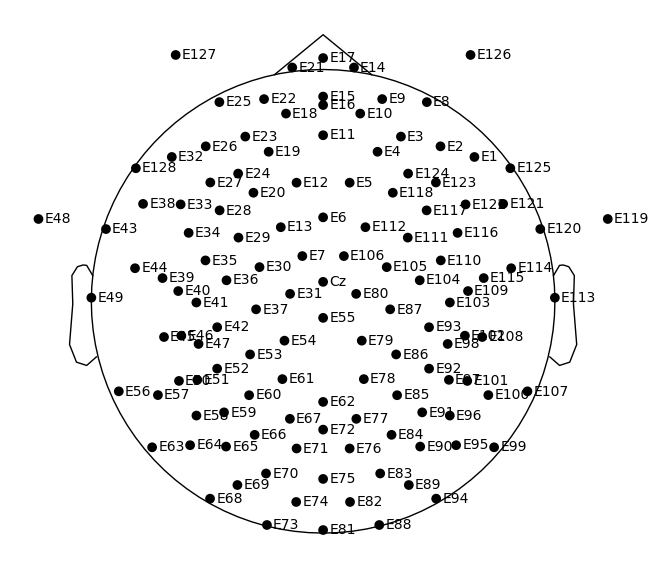

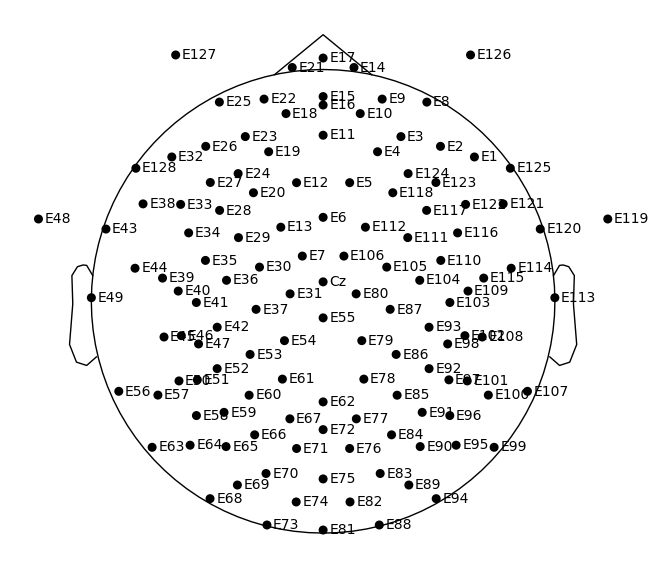

In [26]:
# plot the montage
montage.plot()

In [27]:
# plot the stimulus channels
raw.copy().pick_types(meg=False, stim=True).plot(start=3, duration=6)

Using pyopengl with version 3.1.6


In [28]:
# Construct epochs
event_id  = {'cond1': 1}
events = mne.find_events(raw, stim_channel='TRON')
tmin, tmax = -1., 10.  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,
    event_id=[event_id['cond1']], tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)

60 events found
Event IDs: [1]


## Frequency analysis
Now we compute the frequency spectrum of the EEG data.
You will already see the peaks at the stimulation frequencies and some of
their harmonics, without any further processing.

The 'classical' PSD plot will be compared to a plot of the SNR spectrum.
SNR will be computed as a ratio of the power in a given frequency bin
to the average power in its neighboring bins.
This procedure has two advantages over using the raw PSD:

* it normalizes the spectrum and accounts for 1/f power decay.

* power modulations which are not very narrow band will disappear.

### Calculate power spectral density (PSD)
The frequency spectrum will be computed using Fast Fourier transform (FFT).
This seems to be common practice in the steady-state literature and is
based on the exact knowledge of the stimulus and the assumed response -
especially in terms of it's stability over time.
For a discussion see e.g.
[Bach & Meigen (1999)](https://doi.org/10.1023/A:1002648202420)

We will exclude the first second of each trial from the analysis:

* steady-state response often take a while to stabilize, and the
  transient phase in the beginning can distort the signal estimate.

* this section of data is expected to be dominated by responses related to
  the stimulus onset, and we are not interested in this.

In MNE we call plain FFT as a special case of Welch's method, with only a
single Welch window spanning the entire trial and no specific windowing
function (i.e. applying a boxcar window).




In [29]:
tmin = 1.
tmax = 10.
fmin = 1.
fmax = 90.
sfreq = epochs.info['sfreq']

spectrum = epochs.compute_psd(
    'welch',
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)
psds, freqs = spectrum.get_data(return_freqs=True)

### Calculate signal to noise ratio (SNR)

SNR - as we define it here - is a measure of relative power:
it's the ratio of power in a given frequency bin - the 'signal' -
to a 'noise' baseline - the average power in the surrounding frequency bins.
This approach was initially proposed by
[Meigen & Bach (1999)](https://doi.org/10.1023/A:1002097208337)

Hence, we need to set some parameters for this baseline - how many
neighboring bins should be taken for this computation, and do we want to skip
the direct neighbors (this can make sense if the stimulation frequency is not
super constant, or frequency bands are very narrow).

The function below does what we want.




In [30]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate((
        np.ones(noise_n_neighbor_freqs),
        np.zeros(2 * noise_skip_neighbor_freqs + 1),
        np.ones(noise_n_neighbor_freqs)))
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode='valid'),
        axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(
        mean_noise, pad_width=pad_width, constant_values=np.nan
    )

    return psd / mean_noise

Now we call the function to compute our SNR spectrum.

As described above, we have to define two parameters.

* how many noise bins do we want?

* do we want to skip the n bins directly next to the target bin?


Tweaking these parameters *can* drastically impact the resulting spectrum,
but mainly if you choose extremes.
E.g. if you'd skip very many neighboring bins, broad band power modulations
(such as the alpha peak) should reappear in the SNR spectrum.
On the other hand, if you skip none you might miss or smear peaks if the
induced power is distributed over two or more frequency bins (e.g. if the
stimulation frequency isn't perfectly constant, or you have very narrow
bins).

Here, we want to compare power at each bin with average power of the
**three neighboring bins** (on each side) and **skip one bin** directly next
to it.




In [31]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3,
                    noise_skip_neighbor_freqs=1)

### Plot PSD and SNR spectra
Now we will plot grand average PSD (in blue) and SNR (in red) ± sd
for every frequency bin.
PSD is plotted on a log scale.




/var/folders/d5/x8txhspx6g51f4gnfx3cbc3w0000gp/T/ipykernel_9954/3303805546.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


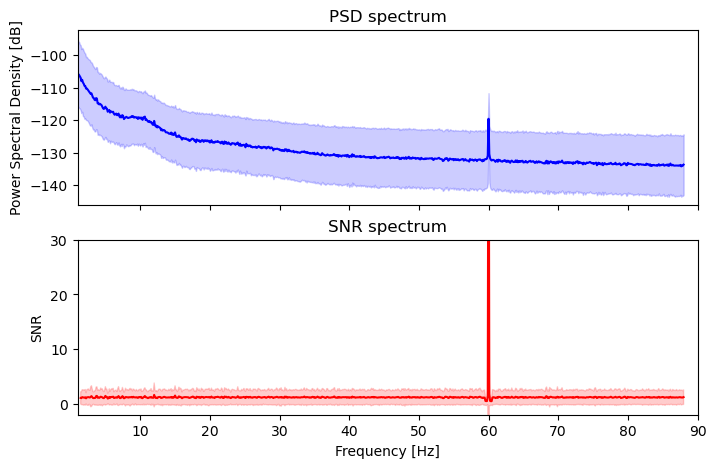

In [32]:
fig, axes = plt.subplots(2, 1, sharex='all', sharey='none', figsize=(8, 5))
freq_range = range(np.where(np.floor(freqs) == 1.)[0][0],
                   np.where(np.ceil(freqs) == fmax - 1)[0][0])

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color='b')
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std,
    color='b', alpha=.2)
axes[0].set(title="PSD spectrum", ylabel='Power Spectral Density [dB]')

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color='r')
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std,
    color='r', alpha=.2)
axes[1].set(
    title="SNR spectrum", xlabel='Frequency [Hz]',
    ylabel='SNR', ylim=[-2, 30], xlim=[fmin, fmax])
fig.show()

You can see that the peaks at the stimulation frequencies (12 Hz, 15 Hz)
and their harmonics are visible in both plots (just as the line noise at
50 Hz).
Yet, the SNR spectrum shows them more prominently as peaks from a
noisy but more or less constant baseline of SNR = 1.
You can further see that the SNR processing removes any broad-band power
differences (such as the increased power in alpha band around 10 Hz),
and also removes the 1/f decay in the PSD.

Note, that while the SNR plot implies the possibility of values below 0
(mean minus sd) such values do not make sense.
Each SNR value is a ratio of positive PSD values, and the lowest possible PSD
value is 0 (negative Y-axis values in the upper panel only result from
plotting PSD on a log scale).
Hence SNR values must be positive and can minimally go towards 0.

## Extract SNR values at the stimulation frequency

Our processing yielded a large array of many SNR values for each trial ×
channel × frequency-bin of the PSD array.

For statistical analysis we obviously need to define specific subsets of this
array. First of all, we are only interested in SNR at the stimulation
frequency, but we also want to restrict the analysis to a spatial ROI.
Lastly, answering your interesting research questions will probably rely on
comparing SNR in different trials.

Therefore we will have to find the indices of trials, channels, etc.
Alternatively, one could subselect the trials already at the epoching step,
using MNE's event information, and process different epoch structures
separately.

Let's only have a look at the trials with 12 Hz stimulation, for now.




### Get index for the stimulation frequency (12 Hz)
Ideally, there would be a bin with the stimulation frequency exactly in its
center. However, depending on your Spectral decomposition this is not
always the case. We will find the bin closest to it - this one should contain
our frequency tagged response.




In [33]:
# find index of frequency bin closest to stimulation frequency
stim_freq1 = 7.5
stim_freq2 = 12
i_bin_1f1 = np.argmin(abs(freqs - stim_freq1))
i_bin_2f1 = np.argmin(abs(freqs - stim_freq1*2))
i_bin_3f1 = np.argmin(abs(freqs - stim_freq1*3))
i_bin_1f2 = np.argmin(abs(freqs - stim_freq2))
i_bin_2f2 = np.argmin(abs(freqs - stim_freq2*2))
i_bin_3f2 = np.argmin(abs(freqs - stim_freq2*3))

### Get indices for the different trial types



In [34]:
i_trial_c1 = np.where(epochs.events[:, 2] == event_id['cond1'])[0]

### Get indices of EEG channels forming the ROI



In [35]:
# Define different ROIs
roi_vis = ['E70','E74','E75','E81','E82', 'E83']  # visual roi

# Find corresponding indices using mne.pick_types()
picks_roi_vis = mne.pick_types(epochs.info, eeg=True, stim=False,
                               exclude='bads', selection=roi_vis)

### Apply the subset, and check the result
Now we simply need to apply our selection and yield a result. Therefore,
we typically report grand average SNR over the subselection.

In this tutorial we don't verify the presence of a neural response.
This is commonly done in the ASSR literature where SNR is
often lower. An F-test or Hotelling T² would be
appropriate for this purpose.



In [36]:
snrs_target = snrs[i_trial_c1, :, i_bin_1f1][:, picks_roi_vis]
print("all trials, SNR at {0}".format(stim_freq1) )
print(f'average SNR (occipital ROI): {snrs_target.mean()}')

all trials, SNR at 7.5
average SNR (occipital ROI): 1.2015415823979232
Channels marked as bad:
none


## Topography of the vSSR
But wait...
As described in the intro, we have decided *a priori* to work with average
SNR over a subset of occipital channels - a visual region of interest (ROI)
- because we expect SNR to be higher on these channels than in other
channels.

Let's check out, whether this was a good decision!

Here we will plot average SNR for each channel location as a topoplot.
Then we will do a simple paired T-test to check, whether average SNRs over
the two sets of channels are significantly different.




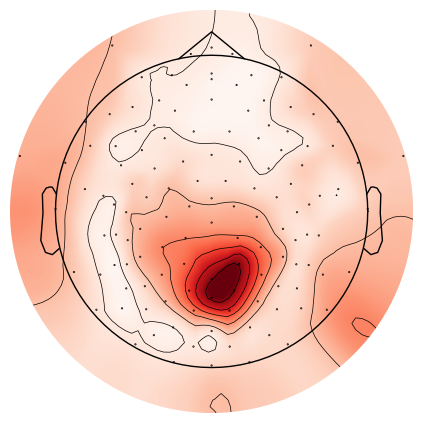

(<matplotlib.image.AxesImage at 0x195ddf6a0>,
 <matplotlib.contour.QuadContourSet at 0x195ddf880>)

In [39]:
# get average SNR at 12 Hz for ALL channels
ch_average_1f1 = snrs[i_trial_c1, :, i_bin_1f1].mean(axis=0)
ch_average_1f2 = snrs[i_trial_c1, :, i_bin_1f2].mean(axis=0)


# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(ch_average_1f2, epochs.info, vlim=(1, None), axes=ax)